In [ ]:
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import wave
import numpy as np
import math
import os
import pickle
import models
import csv

import calculate_features as cf
import models


In [ ]:
np.random.seed(200)
regime = 'iemocap'

In [ ]:
def get_params(regime):
  if regime == 'iemocap':
    #available_emotions = ['ang', 'exc', 'fru', 'neu', 'sad','hap']
    available_emotions = ['ang', 'exc', 'neu', 'sad']
    path_to_samples = 'iem_samples/'
    conf_matrix_prefix = 'iemocap'
    framerate = 44100
    return available_emotions, '', '', '', path_to_samples, conf_matrix_prefix, framerate, '', 0

available_emotions, path_to_wav, path_to_transcription, path_to_labels, path_to_samples, conf_matrix_prefix, framerate, labels_file, label_pos = get_params(regime)

segmentation = 'by_phrase'

types = {1: np.int8, 2: np.int16, 4: np.int32}


In [ ]:
def open_wav(path_to_wav, filename):
  wav = wave.open(path_to_wav + filename, mode="r")
  (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
  content = wav.readframes(nframes)

  samples = np.fromstring(content, dtype=types[sampwidth])
  return (nchannels, sampwidth, framerate, nframes, comptype, compname), samples

def read_lines(f):
  lines = open(f, 'r').read()
  return np.array(lines.split('\n'))


def get_needed_lines(lines, i, subline):
  result = []
  j = i
  condition = True
  while condition:
    if lines[j][:len(subline)] == subline:
      result.append(lines[j])
      j += 1
    else:
      condition = False
  return result, j

def get_label(expert_grades):
  u = np.unique(expert_grades)
  grade = u[0]
  count = expert_grades[expert_grades == grade].shape[0]
  for ui in u:
    current_count = expert_grades[expert_grades == ui].shape[0]
    if current_count > count:
      grade = ui
      count = current_count
  return grade


In [ ]:
def get_emotions(path_to_emotions, filename):
  f = open(path_to_emotions + filename, 'r').read()
  # print f
  # print f.split('\n')
  f = np.array(f.split('\n'))#np.append(np.array(['']), np.array(f.split('\n')))
  c = 0
  idx = f == ''
  idx_n = np.arange(len(f))[idx]
  emotion = []
  for i in range(len(idx_n) - 2):
    g = f[idx_n[i]+1:idx_n[i+1]]
    head = g[0]
    i0 = head.find(' - ')
    start_time = float(head[head.find('[') + 1:head.find(' - ')])
    end_time = float(head[head.find(' - ') + 3:head.find(']')])
    actor_id = head[head.find(filename[:-4]) + len(filename[:-4]) + 1:head.find(filename[:-4]) + len(filename[:-4]) + 5]
    emo = head[head.find('\t[') - 3:head.find('\t[')]
    vad = head[head.find('\t[') + 1:]

    v = float(vad[1:7])
    a = float(vad[9:15])
    d = float(vad[17:23])
    
    emotion.append({'start':start_time, 
                    'end':end_time,
                    'id':filename[:-4] + '_' + actor_id,
                    'v':v,
                    'a':a,
                    'd':d,
                    'emotion':emo})
  return emotion

In [ ]:

#sessions = ['Session1','Session2','Session3','Session4','Session5']
sessions = ['Session1','Session2']

def read_iemocap_data():
  data = []
  for session in sessions:
    print( session)
    path_to_wav = 'iemocap_data/' + session + '/dialog/wav/'
    path_to_emotions = 'iemocap_data/' + session + '/dialog/EmoEvaluation/'
    path_to_transcriptions = 'iemocap_data/' + session + '/dialog/transcriptions/'

    files = os.listdir(path_to_wav)
    files = [f[:-4] for f in files]
    print( len(files))
    print( files)
    for f in files:
      emotions = get_emotions(path_to_emotions, f + '.txt')
      wav = open_wav(path_to_wav, f + '.wav')
      sample = split_wav(wav, emotions)

      transcriptions = get_transcriptions(path_to_transcriptions, f + '.txt')
      for ie, e in enumerate(emotions):
        if e['emotion'] in available_emotions:
          e['signal'] = sample[ie]['left']
          #e['right'] = sample[ie]['right']
          e['transcription'] = transcriptions[e['id']]
          data.append(e)
  return data

In [ ]:
def get_transcriptions(path_to_transcriptions, filename):
  f = open(path_to_transcriptions + filename, 'r').read()
  f = np.array(f.split('\n'))
  transcription = {}

  for i in range(len(f) - 1):
    g = f[i]
    i1 = g.find(': ')
    i0 = g.find(' [')
    ind_id = g[:i0]
    ind_ts = g[i1+2:]
    transcription[ind_id] = ind_ts
  return transcription

In [ ]:
def read_data():
  if regime == 'aibo4' or regime == 'aibo5':
    return read_aibo_data()
  else:
    return read_iemocap_data()

In [ ]:
def split_wav(wav, emotions):
  (nchannels, sampwidth, framerate, nframes, comptype, compname), samples = wav
  duration = nframes / framerate

  left = samples[0::nchannels]
  right = samples[1::nchannels]

  frames = []
  for ie, e in enumerate(emotions):
    start = e['start']
    end = e['end']

    e['right'] = right[int(start * framerate):int(end * framerate)]
    e['left'] = left[int(start * framerate):int(end * framerate)]

    frames.append({'left':e['left'], 'right': e['right']})
  return frames

In [ ]:
def check_all_finite(X):
  X = np.asanyarray(X)
  if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
          and not np.isfinite(X).all()):
    return True
  else:
    return False

def to_categorical(y):
  y_cat = np.zeros((len(y), len(available_emotions)), dtype=int)
  for i in range(len(y)):
    y_cat[i, :] = np.array(np.array(available_emotions) == y[i], dtype=int)

  return y_cat

def save_sample(x, y, name):
  with open(name, 'w') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    for i in range(x.shape[0]):
      row = x[i, :].tolist()
      row.append(y[i])
      w.writerow(row)

In [ ]:
def load(name):
  with open(name, 'r') as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    x = []
    y = []
    for row in r:
      x.append(row[:-1])
      y.append(row[:-1])
  return np.array(x), np.array(y)

def get_features(data, save=True, path=path_to_samples):
  failed_samples = []
  for di, d in enumerate(data):
    if di%1000 == 0: 
      print(di, ' out of ', len(data))
    st_features = cf.calculate_features(d['signal'], framerate, None).T
    x = []
    y = []
    for f in st_features:
      if f[1] > 1.e-4:
        x.append(f)
        y.append(d['emotion'])
    x = np.array(x, dtype=float)
    y = np.array(y)


    if save:
      save_sample(x, y, path + d['id'] + '.csv')
  return x, y

def get_field(data, key):
  return np.array([e[key] for e in data])



In [ ]:
def balance_sample(x, y, size):
  labels = np.unique(y)
  xc = {}
  yc = {}
  for l in labels:
    xc[l] = x[y == l]
    yc[l] = y[y == l]

  s = size / len(labels)

  tx = np.zeros((s*len(labels), x.shape[1]), dtype=float)
  ty = np.zeros(s*len(labels), dtype=str)
  for i in range(len(labels)):
    j = i*s
    n = xc[labels[i]].shape[0]

    idx = np.random.randint(low=0, high=n, size=s)
    tx[j:j+s, :] = xc[labels[i]][idx, :]
    ty[j:j+s] = yc[labels[i]][idx]

  return tx, ty


In [ ]:
def get_sample(idx, path):
  tx = []
  ty = []
  for i in idx:
    x, y = load(path + '/' + i + '.csv')
    if len(x) < 40:
      tx.append(np.array(x))
      #tx.append(np.array(x, dtype=float))
      ty.append(np.array(y))

  tx = np.array(tx)
  ty = np.array(ty)
  return tx, ty

In [ ]:
def normalize(x):
  gminx = np.zeros(x[0].shape[1]) + 1.e5
  gmaxx = np.zeros(x[0].shape[1]) - 1.e5
  for i in range(x.shape[0]):
    q = x[i]
    minx = np.min(q, axis=0)
    maxx = np.max(q, axis=0)

    for s in range(x[0].shape[1]):
      if gminx[s] > minx[s]:
        gminx[s] = minx[s]
      if gmaxx[s] < maxx[s]:
        gmaxx[s] = maxx[s]

  for i in range(x.shape[0]):
    for s in range(x[0].shape[1]):
      x[i][:, s] = (x[i][:, s] - gminx[s]) / float(gmaxx[s] - gminx[s])


  return x

In [ ]:
def grow_sample(x, y, n=10000):
  xg = []
  yg = []
  eps = 5.*1.e-2
  for i in range(n):
    j = np.random.randint(x.shape[0])
    x0 = x[j]
    x0 += eps * np.random.normal(0, 1, size=x0.shape)
    y0 = y[j]
    xg.append(x0)
    yg.append(y0)
  return np.array(xg), np.array(yg)

def reshape_for_dense(x, y):
  j = 0
  xr = []
  yr = []
  for i in range(x.shape[0]):
    for k in xrange(x[i].shape[0]):
      xr.append(x[i][k, :])
      yr.append(y[i])
  return np.array(xr), np.array(yr)


def pad_sequence(x, ts):
  xp = []
  for i in range(x.shape[0]):
    x0 = np.zeros((ts, x[i].shape[0]), dtype=float)
    if ts > x[i].shape[0]:
      a=ts-1
      x0 = x[i]
    else:
      maxe = np.sum(x[i])
      for j in range(x[i].shape[0] - ts):
        if np.sum(x[i]) > maxe:
          x0 = x[i]
          maxe = np.sum(x[i])
    xp.append(x0)
  return np.array(xp)



In [ ]:
data = np.array(read_data())
print( data)
print( len(data))

ids = get_field(data, 'id')
emotions = get_field(data, 'emotion')
print( np.unique(emotions))

for i in range(len(available_emotions)):
    print( available_emotions[i], emotions[emotions == available_emotions[i]].shape[0])

parts = 5
permutation = np.random.permutation(len(data))
permuted_ids = ids[permutation]

step = len(data) / parts

preds = []
trues = []

get_features(data)

In [ ]:
for part in range(parts):
  i0 = int(step * part)
  i1 = int(step * (part + 1))

  train_idx = np.append(permuted_ids[:i0], permuted_ids[i1:])
  test_idx = permuted_ids[i0:i1]

  train_x, train_y = get_sample(train_idx, path_to_samples)



  # energies = []
  # for i in xrange(train_x.shape[0]):
  #   energies.append(np.mean(train_x[i][:, 1]))

  # quantile = 0.5
  # largest_energy_idx = np.argsort(energies)[:int(quantile*len(energies))]

  # train_x = train_x[largest_energy_idx]
  # train_y = train_y[largest_energy_idx]

  test_x, test_y = get_sample(test_idx, path_to_samples)

  # train_x = normalize(train_x)
  # test_x = normalize(test_x)

  #train_x, train_y = grow_sample(train_x, train_y, 10000)
  #train_x, train_y = reshape_for_dense(train_x, train_y)
  print(train_x.shape)
  print(train_y.shape)


In [ ]:
import glob
import librosa
import librosa.display
import numpy as np
import _pickle as pickle
from sklearn import svm
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn import tree

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
                                              sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


def parse_audio_files(path):
    features, labels = np.empty((0, 193)), np.empty(0)
    labels = []
    for fn in glob.glob(path):
        try:
            mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
        except Exception as e:
            print("Error encountered while parsing file: ", fn)
            continue
        ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
        features = np.vstack([features, ext_features])
        labels = np.append(labels, fn.split("_")[1].split(".")[0])
        print(fn)
    return np.array(features), np.array(labels)


tr_features, tr_labels = parse_audio_files('./train_sounds1/*.wav')

print(tr_labels)

tr_features = np.array(tr_features, dtype=pd.Series)
tr_labels = np.array(tr_labels, dtype=pd.Series)

X=tr_features.astype(int)
y=tr_labels.astype(str)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

filename = 'clf_Model_protocol_tree.sav'

pickle.dump(clf, open(filename, 'wb'), protocol=2)

print('Model Saved..')
print('Score:', clf.score(X=tr_features.astype(int), y=tr_labels.astype(str)))

In [ ]:
# Method to extract features from speech using librosa


def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
                                              sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


# List to store file names
target_files = []

# Method to extract label name and extract features from audio file


def parse_audio_files(path):
    labels = []
    features = np.empty((0, 193))
    for fn in glob.glob(path):
        try:
            mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
        except Exception as e:
            print("Error encountered while parsing file: ", fn)
            continue
        ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
        features = np.vstack([features, ext_features])
        labels = np.append(labels, fn.split("_")[3].split(".")[0])
        target_files.append(fn)
    return np.array(features), np.array(labels)


# Get labels and features of audion file of specified path
ts_features, ts_labels = parse_audio_files('./test_20/*.wav')

# Convert features and labels to the pandas Series data type
ts_features = np.array(ts_features, dtype=pd.Series)
ts_labels = np.array(ts_labels, dtype=pd.Series)

# Trained Model file name
filename = 'clf_Model_protocol_tree.sav'

# Load saved model from file
model = pickle.load(open(filename, 'rb'))

# Predict the emotion class
prediction = model.predict(ts_features)

# True labels
test_true = ts_labels

# List to store prediction
test_predicted = []

# Iterate over model prediction and store it into list
for i, val in enumerate(prediction):
    test_predicted.append(val)


# Accuracy score of model
print('Accuracy Score of Decision Tree model is:', accuracy_score(test_true, test_predicted))

# Number of corrected prediction
print('Number of correct prediction by using Decision Tree is:', accuracy_score(test_true, test_predicted, normalize=False), 'out of', len(ts_labels))

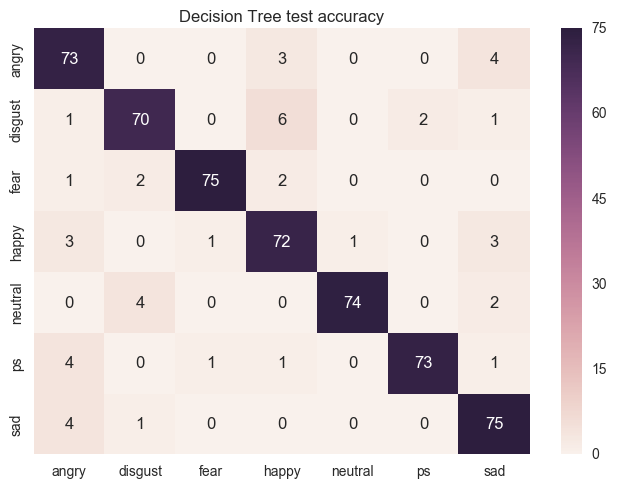

In [ ]:
# Plotting confusion matrix
matrix = confusion_matrix(test_true, test_predicted)
classes = list(set(ts_labels))
classes.sort()
df = pd.DataFrame(matrix, columns=classes, index=classes)
plt.figure()
plt.title('Decision Tree test accuracy')
sn.heatmap(df, annot=True)

plt.show()